In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import bicker.emulator as BICKER
import time
from scipy import interpolate

plt.rcParams['text.usetex'] = True

2023-10-04 09:00:10.942442: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rneveux/local/lib:/home/rneveux/lib:/home/rneveux/cuba
2023-10-04 09:00:10.942466: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Start by loading the ids corresponding to unseen data.

In [2]:
test_ids = np.load("/home/rneveux/bispectrum/BICKER/bicker-cache/powerspec/split/test.npy")

Next load the cosmology for each id.

In [3]:
cosmos = np.load(f"/home/rneveux/bispectrum/theory/cosmologies/lnAs/eft_cosmologies_noDQ1.npy")[test_ids]

Next load the kernel for each id.

In [4]:
kernels = []
for i in test_ids:
    kernels.append(np.loadtxt(f"/home/rneveux/kernels_EFT/pk/z0.8/lnAs/Omfid.31377/pk_kernels_{i}.txt"))
kernels = np.stack(kernels)

Initalise the emulator for the monopole.

In [5]:
emu = {ell: BICKER.power(ell) for ell in [0,2,4]}

2023-10-04 09:01:15.552395: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rneveux/local/lib:/home/rneveux/lib:/home/rneveux/cuba
2023-10-04 09:01:15.552435: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-04 09:01:15.552459: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (worker085): /proc/driver/nvidia/version does not exist
2023-10-04 09:01:15.552821: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Make for the monopole specific kernels for the entire test set. This cell looks a mess but this is not the expected way to use the emulator. Using the `.emu_predict` method is much cleaner. We make predictions in this way because we want to have predictions for the bias independent kernels.

In [6]:
preds = {}
for ell in [0,2,4]:
    start = time.time()
    preds[ell] = emu[ell].models[0].predict(emu[ell].scalers[0][0].transform(cosmos))
    preds[ell] = emu[ell].scalers[0][1].inverse_transform(preds[ell]).reshape(test_ids.shape[0], int(preds[ell].shape[1]/emu[ell].kbins.shape[0]), emu[ell].kbins.shape[0])
    print(f"{test_ids.shape[0]} predictions in {time.time()-start} seconds!")

2000 predictions in 0.3091697692871094 seconds!
2000 predictions in 0.1999199390411377 seconds!
2000 predictions in 0.1813044548034668 seconds!


In [7]:
cov = np.load('/home/rneveux/covariance_matrix/cov_FirstGenMocks_EZmock_Cubic_LRG_z0.800_pk0_pk2_pk4.npy', allow_pickle=True).item()

In [14]:
error = [np.sqrt(np.diag(cov['cov'])[i*40:(i+1)*40]) for i in range(3)]
cov['k']
fun = [interpolate.interp1d(cov['k']['Pk']['0'], error[i], fill_value="extrapolate", kind="cubic") for i in range(3)]
error = {j: fun[i](emu[0].kbins) for i,j in enumerate([0,2,4])}

Next we loop over all the kernels and compare the prediction from the emulator to the truth for a single cosmlogy as well as plotting the ratio of the emulator prediction to the truth for all samples in the test set.

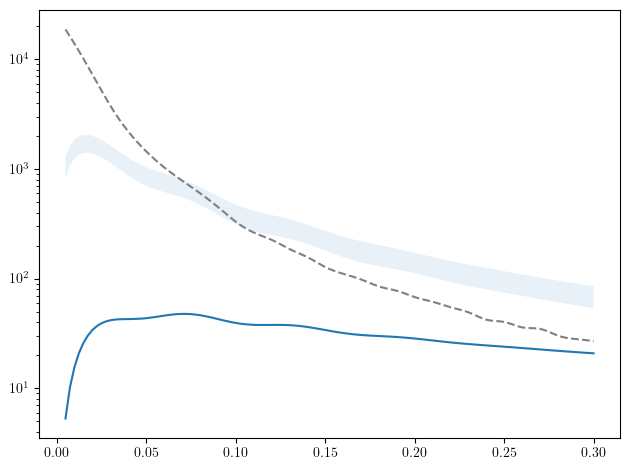

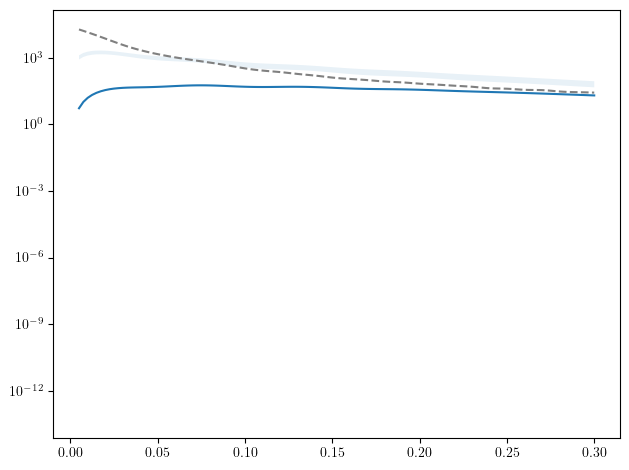

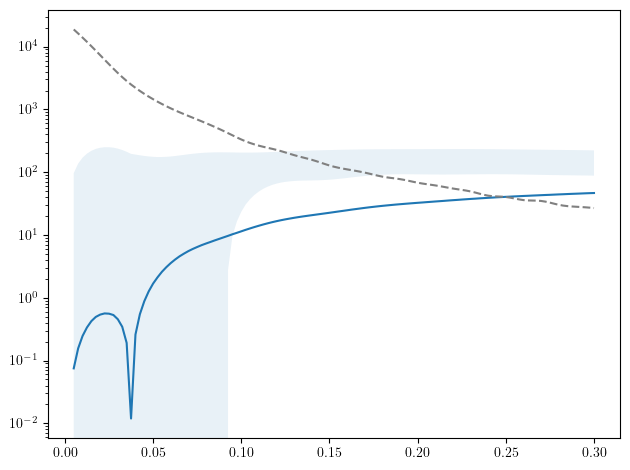

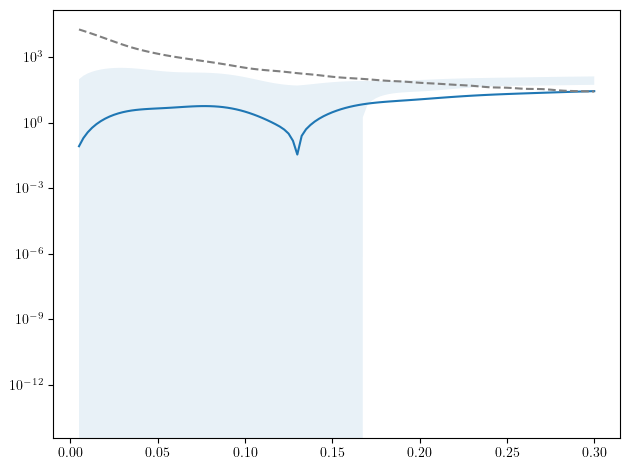

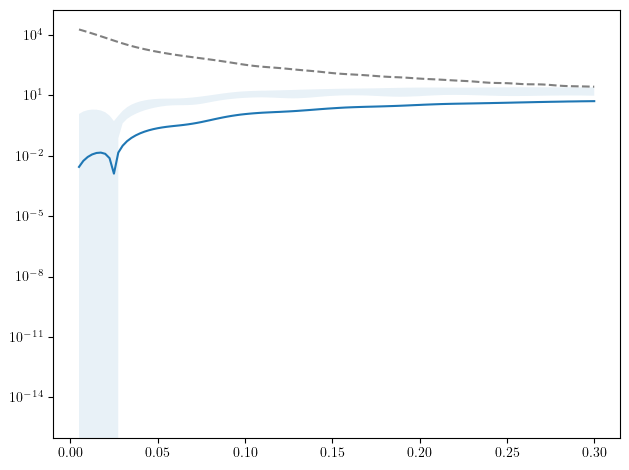

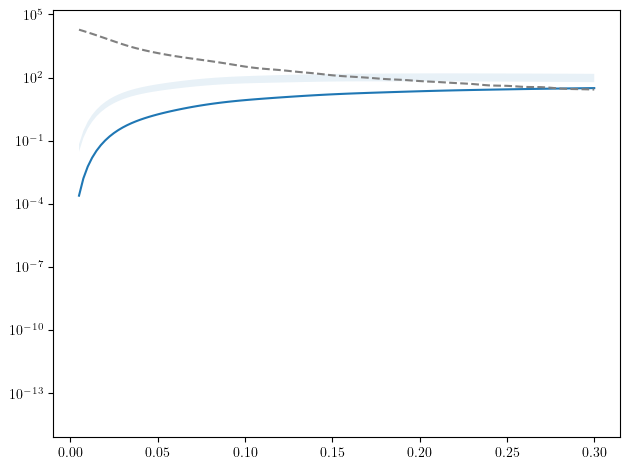

In [18]:
pole_col_dict = {0: np.arange(16), 2: np.arange(17,28), 4: np.append(np.arange(28,33)[::-1], 16)[::-1],
                 'extra': np.arange(34,37)}

multi = 4

for i,j in enumerate(pole_col_dict[multi]):
    #fig, ax = plt.subplots(1,2, figsize=(12,6))
    mean_norm = np.abs(np.mean((kernels[:,j,:]-preds[multi][:,i,:]), axis=0))
    std_norm = np.std((kernels[:,j,:]-preds[multi][:,i,:]), axis=0)
    
    #ax[0].plot(emu[0].kbins, emu[0].kbins*kernels[200,j,:])
    #ax[0].plot(emu[0].kbins, emu[0].kbins*preds[0][200,i,:], linestyle='--')
    
    #ax[1].plot(emu[0].kbins, emu[0].kbins*mean_norm) #, alpha=0.1, color='tab:blue')
    #ax[1].fill_between(emu[0].kbins, mean_norm-std_norm, mean_norm+std_norm, alpha=.1)
    #ax[1].axhline(0., linestyle='--', color='grey')
    #ax[1].plot(emu[0].kbins,error[0], linestyle='--', color='grey')
    plt.plot(emu[multi].kbins, emu[multi].kbins*mean_norm) #, alpha=0.1, color='tab:blue')
    plt.fill_between(emu[multi].kbins, mean_norm-std_norm, mean_norm+std_norm, alpha=.1)
    plt.axhline(0., linestyle='--', color='grey')
    plt.plot(emu[multi].kbins,error[multi], linestyle='--', color='grey')
    #ax[1].axhline(0., linestyle='--', color='grey')
    #ax[1].set_ylim(2*np.min(mean_norm-std_norm), 2*np.max(mean_norm+std_norm))
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

Finally we make a prediction for the galaxy monopole with $b_1=1.$ and all other bias parameters equal to zero.

[[ 1.    1.    2.    2.    4.    4.    0.25 -2.   -1.    0.2   0.1  -0.1
   0.01 10.    0.24  0.12]]
(1, 16)


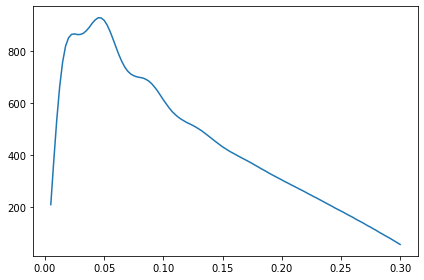

In [8]:
plt.plot(emu.kbins, emu.kbins*emu.emu_predict(cosmos[200], np.array([2,-1,.1,-.1,100,5]))[0])
plt.tight_layout()
plt.show()

In [7]:
id_cosmo = 200

In [15]:
%%time

h = cosmos[id_cosmo][2]
omega_cdm = cosmos[id_cosmo][0]
omega_b = cosmos[id_cosmo][1]
sigma8_input = cosmos[id_cosmo][3]
ns = cosmos[id_cosmo][4]

params_cosmo_s8 = {'k_output_values':2.0,'output': 'tCl mPk','z_max_pk': 3.,'P_k_max_h/Mpc': 50., 'z_pk':.8,
            'omega_cdm':omega_cdm,'omega_b':omega_b,'h':h,
            'sigma8':sigma8_input,
            'n_s':ns}

c_lin = Class()
c_lin.set(params_cosmo_s8)
c_lin.set({'output':'mPk',
      })

c_lin.compute()

As_rescale = c_lin.A_s()/c_lin.sigma8()**2*sigma8_input**2

params_cosmo = {'k_output_values':2.0,'output': 'tCl mPk','z_max_pk': 3.,'P_k_max_h/Mpc': 50., 'z_pk':.8,
            'omega_cdm':omega_cdm,'omega_b':omega_b,'h':h,
            'A_s': As_rescale,
            'n_s':ns}

c = Class()
c.set(params_cosmo)
c.set({'output':'mPk',
    'non linear':'PT',
    'IR resummation':'Yes',
    'Bias tracers':'Yes',
    'cb':'Yes',
    'RSD':'Yes',
    'AP':'Yes',
    'Omfid':.31377
   })

c.compute()

CPU times: user 24 s, sys: 59.9 ms, total: 24.1 s
Wall time: 4.22 s


In [16]:
c.initialize_output(np.arange(.005,.3025,0.0025), .8, 119)

b1 = 2
b2 = -1
bG2 = .1
bGamma3 = -.1
b4 = 0
c0 = 5
Pshot = 0

pk_class = {0: c.pk_gg_l0(b1, b2, bG2, bGamma3, c0, Pshot, b4),
               2: c.pk_gg_l2(b1, b2, bG2, bGamma3, c0, b4),
               4: c.pk_gg_l4(b1, b2, bG2, bGamma3, c0, b4),}
pk_emul = {}
for ell in [0,2,4]:
    pk_emul[ell] = emu[ell].emu_predict(cosmos[id_cosmo], np.array([b1,b2,bG2,bGamma3,b4,c0, Pshot]))[0]

[[ 1.    1.    2.    2.    4.    4.    0.25 -2.   -1.    0.2   0.1  -0.1
   0.01 10.    0.24  0.12]]
(1, 16)
[[ 1.    1.    2.    2.    4.   -2.   -1.    0.2   0.1  10.    0.12]]
(1, 11)
[[ 1.   1.   2.   4.  -1.   0.1 10. ]]
(1, 7)


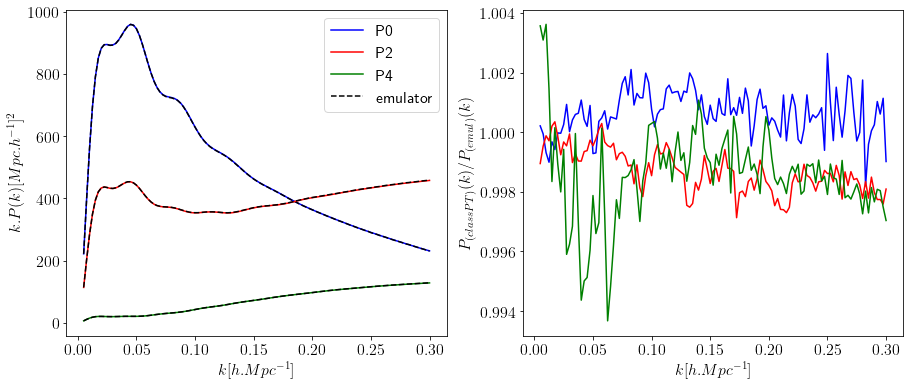

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,6))

color = {0:'b', 2:'r', 4:'g'}


for ell in [0,2,4]:
    if ell==4: lab='emulator'
    else: lab=None
    ax[0].plot(np.arange(.005,.3025,0.0025), np.arange(.005,.3025,0.0025)*pk_class[ell], color=color[ell], label=f'P{ell}')
    ax[0].plot(np.arange(.005,.3025,0.0025), np.arange(.005,.3025,0.0025)*pk_emul[ell], linestyle='--', color='k', label=lab)
    ax[0].set_xlabel(r'$k [h.Mpc^{-1}]$',fontsize=16)
    ax[0].set_ylabel(r'$k.P(k) [Mpc.h^{-1}]^2$',fontsize=16)
    ax[0].tick_params(axis='both', which='major', labelsize=16)
    ax[0].legend(fontsize=16)

    ax[1].plot(emu[ell].kbins, pk_class[ell]/pk_emul[ell], color=color[ell])
    ax[1].set_xlabel(r'$k [h.Mpc^{-1}]$',fontsize=16)
    ax[1].set_ylabel(r'$P_{(classPT)}(k)/P_{(emul)}(k) $',fontsize=16)
    ax[1].tick_params(axis='both', which='major', labelsize=16)
#ax[1].axhline(0., linestyle='--', color='grey')

#for i,j in enumerate(pole_col_dict[0]):
#    ax[1].plot(emu.kbins, (kernels[1185,j,:]/preds[1185,i,:]).T, alpha=0.1, color='tab:blue')
#ax[1].set_ylim(0.995, 1.005)